In [1]:
import ray

s3_uri = "s3://anonymous@air-example-data-2/imagenette2/train/"

In [2]:
try:
    ray.shutdown()
except:
    pass
ray.init(address="auto")

2024-05-09 19:36:31,035	INFO worker.py:1540 -- Connecting to existing Ray cluster at address: 10.244.28.10:6379...
2024-05-09 19:36:32,012	INFO worker.py:1715 -- Connected to Ray cluster. View the dashboard at http://10.244.28.10:8265 
[2024-05-09 19:36:32,018 I 2032 2032] logging.cc:230: Set ray log level from environment variable RAY_BACKEND_LOG_LEVEL to -1


Python version:,3.8.10
Ray version:,2.9.3
Dashboard:,http://10.244.28.10:8265


(raylet) [2024-05-09 19:37:08,745 I 2138 2138] logging.cc:230: Set ray log level from environment variable RAY_BACKEND_LOG_LEVEL to -1
(raylet, ip=10.244.26.10) [2024-05-09 19:37:10,812 I 733 733] logging.cc:230: Set ray log level from environment variable RAY_BACKEND_LOG_LEVEL to -1
(raylet, ip=10.244.29.10) [2024-05-09 19:38:58,822 I 757 757] logging.cc:230: Set ray log level from environment variable RAY_BACKEND_LOG_LEVEL to -1
(raylet, ip=10.244.29.10) [2024-05-09 19:43:32,040 I 1078 1078] logging.cc:230: Set ray log level from environment variable RAY_BACKEND_LOG_LEVEL to -1
(_MapWorker pid=1078, ip=10.244.29.10) Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
0.0%m(_MapWorker pid=1078, ip=10.244.29.10) 
0.0%m(_MapWorker pid=1078, ip=10.244.29.10) 
(raylet) [2024-05-09 19:43:33,566 I 2459 2459] logging.cc:230: Set ray log level from environment variable RAY_BACKEND_LOG_LEVEL to -1 [repeated 3x a

### Step 1: Reading the Dataset from S3

In [3]:
ds = ray.data.read_images(s3_uri, mode="RGB")

In [4]:
ds

Dataset(
   num_blocks=200,
   num_rows=9469,
   schema={image: numpy.ndarray(ndim=3, dtype=uint8)}
)

In [5]:
ds.schema()

Column  Type
------  ----
image   numpy.ndarray(ndim=3, dtype=uint8)

### Step 2: Inference on a single batch

In [6]:
single_batch = ds.take_batch(10)

2024-05-09 19:38:57,761	INFO set_read_parallelism.py:115 -- Using autodetected parallelism=200 for stage ReadImage to satisfy DataContext.get_current().min_parallelism=200.
2024-05-09 19:38:57,855	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage] -> LimitOperator[limit=10]
2024-05-09 19:38:57,856	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2024-05-09 19:38:57,856	INFO streaming_executor.py:115 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


[dataset]: Run `pip install tqdm` to enable progress reporting.


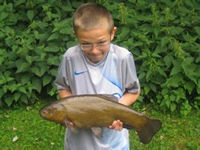

In [7]:
from PIL import Image

img = Image.fromarray(single_batch["image"][0])
img

In [8]:
import torch
from torchvision.models import ResNet152_Weights
from torchvision import transforms
from torchvision import models

weights = ResNet152_Weights.IMAGENET1K_V1

# Load the pretrained resnet model and move to GPU if one is available.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
device

device(type='cuda')

In [10]:
model = models.resnet152(weights=weights).to(device)
model.eval()

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
10.2%IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

77.5%IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

85.7%IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

C

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
imagenet_transforms = weights.transforms
transform = transforms.Compose([transforms.ToTensor(), imagenet_transforms()])

In [12]:
transformed_batch = [transform(image) for image in single_batch["image"]]

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [13]:
with torch.inference_mode():
    prediction_results = model(torch.stack(transformed_batch).to(device))
    classes = prediction_results.argmax(dim=1).cpu()

In [14]:
del model

In [15]:
labels = [weights.meta["categories"][i] for i in classes]

In [16]:
labels

['tench',
 'tench',
 'tench',
 'tench',
 'tench',
 'tench',
 'tench',
 'tench',
 'tench',
 'tench']

### Step 3: Scaling up to the full Dataset with Ray Data

##### Preprocessing

In [17]:
import numpy as np
from typing import Any, Dict

def preprocess_image(row: Dict[str, np.ndarray]):
    return {
        "original_image": row["image"],
        "transformed_image": transform(row["image"]),
    }

In [18]:
transformed_ds = ds.map(preprocess_image)

##### Model Inference

In [19]:
from typing import Dict
import numpy as np
import torch


class ResnetModel:
    def __init__(self):
        self.weights = ResNet152_Weights.IMAGENET1K_V1
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = models.resnet152(weights=self.weights).to(self.device)
        self.model.eval()

    def __call__(self, batch: Dict[str, np.ndarray]):
        # Convert the numpy array of images into a PyTorch tensor.
        # Move the tensor batch to GPU if available.
        torch_batch = torch.from_numpy(batch["transformed_image"]).to(self.device)
        with torch.inference_mode():
            prediction = self.model(torch_batch)
            predicted_classes = prediction.argmax(dim=1).detach().cpu()
            predicted_labels = [
                self.weights.meta["categories"][i] for i in predicted_classes
            ]
            return {
                "predicted_label": predicted_labels,
                "original_image": batch["original_image"],
            }

In [20]:
predictions = transformed_ds.map_batches(
    ResnetModel,
    concurrency=4,  # Use 4 GPUs. Change this number based on the number of GPUs in your cluster.
    num_gpus=1,  # Specify 1 GPU per model replica.
    batch_size=720,  # Use the largest batch size that can fit on our GPUs
)

##### Verify and save results

In [21]:
prediction_batch = predictions.take_batch(5)

2024-05-09 19:43:31,105	INFO set_read_parallelism.py:115 -- Using autodetected parallelism=200 for stage ReadImage to satisfy DataContext.get_current().min_parallelism=200.
2024-05-09 19:43:31,106	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage->Map(preprocess_image)] -> ActorPoolMapOperator[MapBatches(ResnetModel)] -> LimitOperator[limit=5]
2024-05-09 19:43:31,107	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2024-05-09 19:43:31,108	INFO streaming_executor.py:115 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
2024-05-09 19:43:31,957	INFO actor_pool_map_operator.py:114 -- MapBa

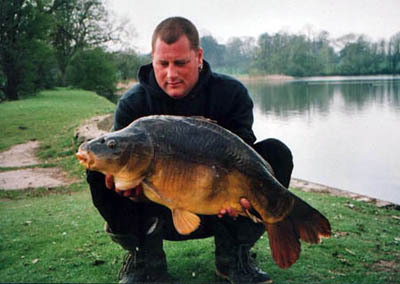

Label:  tench


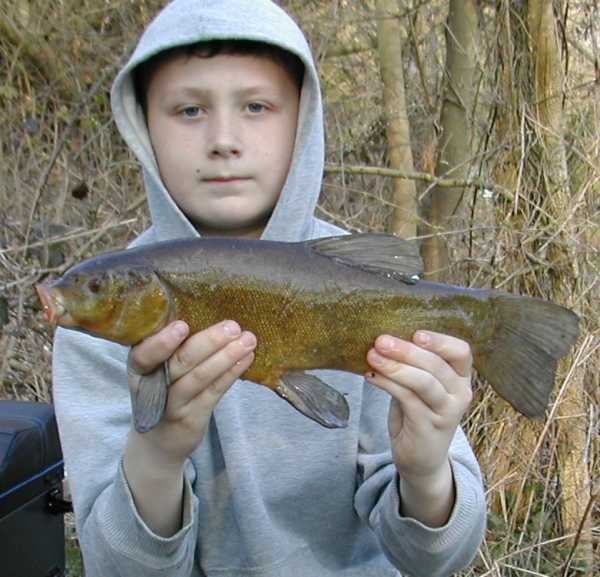

Label:  tench


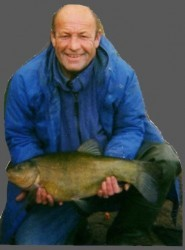

Label:  tench


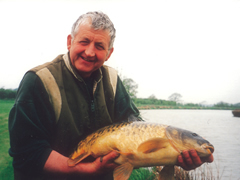

Label:  tench


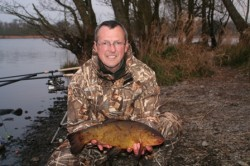

Label:  tench


In [22]:
from PIL import Image

for image, prediction in zip(
    prediction_batch["original_image"], prediction_batch["predicted_label"]
):
    img = Image.fromarray(image)
    display(img)
    print("Label: ", prediction)

In [23]:
results_dir = "/home/artifacts/results/"

# First, drop the original images to avoid them being saved as part of the predictions.
# Then, write the predictions in parquet format to a path with the `local://` prefix
# to make sure all results get written on the head node.
predictions.drop_columns(["original_image"]).write_parquet(f"local://{results_dir}")
print(f"Predictions saved to `{results_dir}`!")

2024-05-09 19:45:08,576	WARNING util.py:546 -- The argument ``compute`` is deprecated in Ray 2.9. Please specify argument ``concurrency`` instead. For more information, see https://docs.ray.io/en/master/data/transforming-data.html#stateful-transforms.
2024-05-09 19:45:08,837	INFO set_read_parallelism.py:115 -- Using autodetected parallelism=200 for stage ReadImage to satisfy DataContext.get_current().min_parallelism=200.
2024-05-09 19:45:08,837	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage->Map(preprocess_image)] -> ActorPoolMapOperator[MapBatches(ResnetModel)] -> TaskPoolMapOperator[MapBatches(fn)] -> TaskPoolMapOperator[Write]
2024-05-09 19:45:08,838	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=False, actor

Predictions saved to `/home/artifacts/results/`!
